# BTC Price 상관관계 분석

## 분석 목표
- 두 개의 일별 데이터를 병합하여 BTC_Price에 영향을 주는 요인 탐색
- 상관계수 히트맵을 통한 변수 간 관계 시각화
- BTC_Price와 상관관계가 높은 상위 10개 변수 도출

In [1]:
# ============================================================
# 셀 1: 라이브러리 Import 및 기본 설정
# ============================================================

# 데이터 처리 및 분석
import pandas as pd
import numpy as np
import os
from pathlib import Path

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows 환경)
plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# pandas 출력 옵션
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✅ 모든 라이브러리가 성공적으로 로드되었습니다.")
print(f"pandas 버전: {pd.__version__}")
print(f"numpy 버전: {np.__version__}")
print(f"seaborn 버전: {sns.__version__}")

✅ 모든 라이브러리가 성공적으로 로드되었습니다.
pandas 버전: 3.0.0
numpy 버전: 2.4.1
seaborn 버전: 0.13.2


In [8]:
# ============================================================
# 셀 2: 분석 설정값 (사용자가 여기만 수정하면 됨)
# ============================================================

# 📁 파일 경로 설정
FILE_PATH_1 = r'./data/processed/merged_정형데이터/daily_data_merged.csv'
FILE_PATH_2 = r'./data/processed/features_daily.csv'

# 📅 날짜 컬럼 후보 리스트 (자동 탐지용)
# 데이터에서 날짜 컬럼으로 사용될 가능성이 높은 컬럼명들
DATE_COLUMN_CANDIDATES = ['date', 'Date', 'DATE', 'datetime', 'Datetime', 'ds', 'DS', 'time', 'Time']

# 📊 상관계수 계산 방법
# 'pearson': 선형 상관관계 측정 (기본값, 정규분포 가정)
# 'spearman': 순위 기반 상관관계 측정 (비선형 관계도 포착 가능)
CORR_METHOD = 'pearson'  # 'spearman'으로 변경 가능

# 🧹 결측치 처리 방식
# True: 결측치가 있는 행 제거 (기본값)
# False: 결측치를 forward fill로 채운 후 남은 결측치만 제거
USE_DROPNA_ONLY = False

# 🎨 히트맵 설정
HEATMAP_FIGSIZE = (16, 12)  # 그래프 크기
HEATMAP_ANNOT_THRESHOLD = 30  # 컬럼 수가 이 값보다 많으면 annot=False

# 💾 출력 파일 경로
OUTPUT_DIR = './outputs'
OUTPUT_FILE = 'corr_heatmap.png'

print("⚙️ 분석 설정 완료")
print(f"\n📁 파일 경로:")
print(f"   파일 1: {FILE_PATH_1}")
print(f"   파일 2: {FILE_PATH_2}")
print(f"\n📊 분석 옵션:")
print(f"   상관계수 방법: {CORR_METHOD}")
print(f"   결측치 처리: {'dropna만 사용' if USE_DROPNA_ONLY else 'forward fill 후 dropna'}")
print(f"\n💾 출력 경로: {os.path.join(OUTPUT_DIR, OUTPUT_FILE)}")

⚙️ 분석 설정 완료

📁 파일 경로:
   파일 1: ./data/processed/merged_정형데이터/daily_data_merged.csv
   파일 2: ./data/processed/features_daily.csv

📊 분석 옵션:
   상관계수 방법: pearson
   결측치 처리: forward fill 후 dropna

💾 출력 경로: ./outputs\corr_heatmap.png


In [9]:
# ============================================================
# 셀 3: CSV 파일 로드
# ============================================================

print("📂 CSV 파일 로드 중...\n")

# 첫 번째 CSV 파일 읽기
try:
    df1 = pd.read_csv(FILE_PATH_1, encoding='utf-8', low_memory=False)
    print(f"✅ 파일 1 로드 성공: {len(df1):,}개 행, {len(df1.columns)}개 컬럼")
    print(f"   컬럼: {list(df1.columns[:5])}..." if len(df1.columns) > 5 else f"   컬럼: {list(df1.columns)}")
except Exception as e:
    print(f"❌ 파일 1 로드 실패: {FILE_PATH_1}")
    print(f"   에러: {e}")
    raise

# 두 번째 CSV 파일 읽기
try:
    df2 = pd.read_csv(FILE_PATH_2, encoding='utf-8', low_memory=False)
    print(f"\n✅ 파일 2 로드 성공: {len(df2):,}개 행, {len(df2.columns)}개 컬럼")
    print(f"   컬럼: {list(df2.columns[:5])}..." if len(df2.columns) > 5 else f"   컬럼: {list(df2.columns)}")
except Exception as e:
    print(f"❌ 파일 2 로드 실패: {FILE_PATH_2}")
    print(f"   에러: {e}")
    raise

print("\n" + "="*80)
print("📊 파일 1 미리보기")
print("="*80)
display(df1.head(3))

print("\n" + "="*80)
print("📊 파일 2 미리보기")
print("="*80)
display(df2.head(3))

📂 CSV 파일 로드 중...

✅ 파일 1 로드 성공: 61개 행, 9개 컬럼
   컬럼: ['Date', 'Yield_10Y', 'Gold_Price_YF', 'BTC_Price_Speed', 'M2_Expansion_Speed']...

✅ 파일 2 로드 성공: 61개 행, 37개 컬럼
   컬럼: ['date', 'n_articles', 'n_sources', 'tone_mean', 'tone_std']...

📊 파일 1 미리보기


,Date,Yield_10Y,Gold_Price_YF,BTC_Price_Speed,M2_Expansion_Speed,USD_Index,Gold_Price_Investing,Open_Interest,BTC_Price
0,20250901,NaN,NaN,NaN,NaN,97.7700,NaN,75.0000,109243.3000
1,20250902,42.7700,3549.3999,NaN,NaN,98.4000,3592.2000,76.0000,111218.3000
2,20250903,42.1100,3593.2000,NaN,NaN,98.1400,3635.5000,77.0000,111716.5000



📊 파일 2 미리보기


,date,n_articles,n_sources,tone_mean,tone_std,tone_neg_share,tone_pos_share,theme_cnt__CRISISLEX_C07_SAFETY,theme_cnt__CRISISLEX_CRISISLEXREC,theme_cnt__ECON_BITCOIN,theme_cnt__ECON_STOCKMARKET,theme_cnt__EPU_CATS_REGULATION,theme_cnt__EPU_ECONOMY,theme_cnt__EPU_ECONOMY_HISTORIC,theme_cnt__EPU_POLICY,theme_cnt__EPU_POLICY_GOVERNMENT,theme_cnt__GENERAL_GOVERNMENT,theme_cnt__LEADER,theme_cnt__TAX_ECON_PRICE,theme_cnt__TAX_ETHNICITY,theme_cnt__TAX_FNCACT,theme_cnt__TAX_FNCACT_PRESIDENT,theme_cnt__TAX_WORLDLANGUAGES,theme_cnt__UNGP_FORESTS_RIVERS_OCEANS,theme_cnt__USPEC_POLICY1,theme_cnt__USPEC_POLITICS_GENERAL1,theme_cnt__WB_1104_MACROECONOMIC_VULNERABILITY_AND_DEBT,theme_cnt__WB_133_INFORMATION_AND_COMMUNICATION_TECHNOLOGIES,theme_cnt__WB_1920_FINANCIAL_SECTOR_DEVELOPMENT,theme_cnt__WB_2432_FRAGILITY_CONFLICT_AND_VIOLENCE,theme_cnt__WB_507_ENERGY_AND_EXTRACTIVES,theme_cnt__WB_678_DIGITAL_GOVERNMENT,theme_cnt__WB_694_BROADCAST_AND_MEDIA,theme_cnt__WB_696_PUBLIC_SECTOR_MANAGEMENT,theme_cnt__WB_698_TRADE,theme_cnt__WB_831_GOVERNANCE,theme_cnt__WB_840_JUSTICE
0,20250901,101,50,1.1086,3.0685,0.4059,0.5446,15,15,90,20,10,14,35,45,12,13,20,57,25,84,19,18,31,28,21,22,21,11,13,17,21,13,42,52,15,14
1,20250902,157,79,0.6798,2.8125,0.2484,0.6879,28,19,137,45,31,29,75,66,21,28,43,71,40,145,38,24,58,52,47,23,47,20,25,19,45,39,58,95,33,15
2,20250903,190,138,-0.2406,3.0548,0.4263,0.5053,59,67,183,53,52,42,116,130,49,57,84,91,75,173,69,59,73,93,93,47,62,54,65,30,59,42,120,107,61,44


In [10]:
# ============================================================
# 셀 4: 날짜 컬럼 변환 (YYYYMMDD 형식)
# ============================================================

print("📅 날짜 컬럼 처리 중...\n")

# 두 파일 모두 'date' 컬럼 사용
date_col_1 = 'Date'
date_col_2 = 'date'

# 날짜 컬럼 존재 확인
if date_col_1 not in df1.columns:
    raise ValueError(f"❌ 파일 1에 '{date_col_1}' 컬럼이 없습니다. 사용 가능한 컬럼: {list(df1.columns)}")

if date_col_2 not in df2.columns:
    raise ValueError(f"❌ 파일 2에 '{date_col_2}' 컬럼이 없습니다. 사용 가능한 컬럼: {list(df2.columns)}")

print(f"✅ 날짜 컬럼 확인: 파일 1, 2 모두 '{date_col_1}' 컬럼 사용")

# ============================================================
# 날짜 컬럼을 datetime 형식으로 변환 (YYYYMMDD 형식)
# ============================================================

print(f"\n🔄 날짜 형식 변환 중 (YYYYMMDD → datetime)...\n")

# 파일 1 날짜 변환
print(f"파일 1 날짜 샘플 (변환 전): {df1[date_col_1].head(3).tolist()}")
df1[date_col_1] = pd.to_datetime(df1[date_col_1], format='%Y%m%d', errors='coerce')
print(f"파일 1 날짜 샘플 (변환 후): {df1[date_col_1].head(3).tolist()}")

# 변환 실패한 날짜 확인
invalid_dates_1 = df1[date_col_1].isna().sum()
if invalid_dates_1 > 0:
    print(f"⚠️  파일 1에서 {invalid_dates_1:,}개 행의 날짜 변환 실패 (제거 예정)")
    df1 = df1.dropna(subset=[date_col_1])

# 파일 2 날짜 변환
print(f"\n파일 2 날짜 샘플 (변환 전): {df2[date_col_2].head(3).tolist()}")
df2[date_col_2] = pd.to_datetime(df2[date_col_2], format='%Y%m%d', errors='coerce')
print(f"파일 2 날짜 샘플 (변환 후): {df2[date_col_2].head(3).tolist()}")

# 변환 실패한 날짜 확인
invalid_dates_2 = df2[date_col_2].isna().sum()
if invalid_dates_2 > 0:
    print(f"⚠️  파일 2에서 {invalid_dates_2:,}개 행의 날짜 변환 실패 (제거 예정)")
    df2 = df2.dropna(subset=[date_col_2])

# 날짜 범위 출력
print(f"\n📆 파일 1 날짜 범위: {df1[date_col_1].min().date()} ~ {df1[date_col_1].max().date()}")
print(f"📆 파일 2 날짜 범위: {df2[date_col_2].min().date()} ~ {df2[date_col_2].max().date()}")

print(f"\n✅ 날짜 변환 완료!")


📅 날짜 컬럼 처리 중...

✅ 날짜 컬럼 확인: 파일 1, 2 모두 'Date' 컬럼 사용

🔄 날짜 형식 변환 중 (YYYYMMDD → datetime)...

파일 1 날짜 샘플 (변환 전): [20250901, 20250902, 20250903]
파일 1 날짜 샘플 (변환 후): [Timestamp('2025-09-01 00:00:00'), Timestamp('2025-09-02 00:00:00'), Timestamp('2025-09-03 00:00:00')]

파일 2 날짜 샘플 (변환 전): [20250901, 20250902, 20250903]
파일 2 날짜 샘플 (변환 후): [Timestamp('2025-09-01 00:00:00'), Timestamp('2025-09-02 00:00:00'), Timestamp('2025-09-03 00:00:00')]

📆 파일 1 날짜 범위: 2025-09-01 ~ 2025-10-31
📆 파일 2 날짜 범위: 2025-09-01 ~ 2025-10-31

✅ 날짜 변환 완료!


In [11]:
# ============================================================
# 셀 5: 두 데이터프레임 병합 (Inner Join)
# ============================================================

print("🔗 데이터 병합 중...\n")

# Inner Join: 두 데이터에 모두 존재하는 날짜만 남김
# suffixes: 같은 컬럼명이 있을 경우 '_df1', '_df2'를 붙여서 구분
df_merged = pd.merge(
    df1,
    df2,
    left_on=date_col_1,
    right_on=date_col_2,
    how='inner',
    suffixes=('_df1', '_df2')
)

print(f"✅ 병합 완료!")
print(f"\n📊 병합 결과:")
print(f"   파일 1 원본: {len(df1):,}개 행")
print(f"   파일 2 원본: {len(df2):,}개 행")
print(f"   병합 후: {len(df_merged):,}개 행 (교집합)")
print(f"   총 컬럼 수: {len(df_merged.columns)}개")

# 날짜 컬럼 중복 제거 (date_col_1만 남기고 date_col_2는 제거)
if date_col_1 != date_col_2 and date_col_2 in df_merged.columns:
    df_merged = df_merged.drop(columns=[date_col_2])
    print(f"\n🧹 중복 날짜 컬럼 제거: '{date_col_2}' 삭제")

# 날짜 컬럼을 인덱스로 설정 (시계열 분석에 유리)
df_merged = df_merged.set_index(date_col_1)
df_merged.index.name = 'date'  # 인덱스 이름 통일

print(f"\n📆 병합 데이터 날짜 범위: {df_merged.index.min().date()} ~ {df_merged.index.max().date()}")
print(f"   총 {len(df_merged)}일치 데이터")

print("\n" + "="*80)
print("📊 병합된 데이터 미리보기")
print("="*80)
display(df_merged.head())

print("\n" + "="*80)
print("📋 컬럼 정보")
print("="*80)
print(df_merged.info())

🔗 데이터 병합 중...

✅ 병합 완료!

📊 병합 결과:
   파일 1 원본: 61개 행
   파일 2 원본: 61개 행
   병합 후: 61개 행 (교집합)
   총 컬럼 수: 46개

🧹 중복 날짜 컬럼 제거: 'date' 삭제

📆 병합 데이터 날짜 범위: 2025-09-01 ~ 2025-10-31
   총 61일치 데이터

📊 병합된 데이터 미리보기


,Yield_10Y,Gold_Price_YF,BTC_Price_Speed,M2_Expansion_Speed,USD_Index,Gold_Price_Investing,Open_Interest,BTC_Price,n_articles,n_sources,tone_mean,tone_std,tone_neg_share,tone_pos_share,theme_cnt__CRISISLEX_C07_SAFETY,theme_cnt__CRISISLEX_CRISISLEXREC,theme_cnt__ECON_BITCOIN,theme_cnt__ECON_STOCKMARKET,theme_cnt__EPU_CATS_REGULATION,theme_cnt__EPU_ECONOMY,theme_cnt__EPU_ECONOMY_HISTORIC,theme_cnt__EPU_POLICY,theme_cnt__EPU_POLICY_GOVERNMENT,theme_cnt__GENERAL_GOVERNMENT,theme_cnt__LEADER,theme_cnt__TAX_ECON_PRICE,theme_cnt__TAX_ETHNICITY,theme_cnt__TAX_FNCACT,theme_cnt__TAX_FNCACT_PRESIDENT,theme_cnt__TAX_WORLDLANGUAGES,theme_cnt__UNGP_FORESTS_RIVERS_OCEANS,theme_cnt__USPEC_POLICY1,theme_cnt__USPEC_POLITICS_GENERAL1,theme_cnt__WB_1104_MACROECONOMIC_VULNERABILITY_AND_DEBT,theme_cnt__WB_133_INFORMATION_AND_COMMUNICATION_TECHNOLOGIES,theme_cnt__WB_1920_FINANCIAL_SECTOR_DEVELOPMENT,theme_cnt__WB_2432_FRAGILITY_CONFLICT_AND_VIOLENCE,theme_cnt__WB_507_ENERGY_AND_EXTRACTIVES,theme_cnt__WB_678_DIGITAL_GOVERNMENT,theme_cnt__WB_694_BROADCAST_AND_MEDIA,theme_cnt__WB_696_PUBLIC_SECTOR_MANAGEMENT,theme_cnt__WB_698_TRADE,theme_cnt__WB_831_GOVERNANCE,theme_cnt__WB_840_JUSTICE
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-09-01,NaN,NaN,NaN,NaN,97.7700,NaN,75.0000,109243.3000,101,50,1.1086,3.0685,0.4059,0.5446,15,15,90,20,10,14,35,45,12,13,20,57,25,84,19,18,31,28,21,22,21,11,13,17,21,13,42,52,15,14
2025-09-02,42.7700,3549.3999,NaN,NaN,98.4000,3592.2000,76.0000,111218.3000,157,79,0.6798,2.8125,0.2484,0.6879,28,19,137,45,31,29,75,66,21,28,43,71,40,145,38,24,58,52,47,23,47,20,25,19,45,39,58,95,33,15
2025-09-03,42.1100,3593.2000,NaN,NaN,98.1400,3635.5000,77.0000,111716.5000,190,138,-0.2406,3.0548,0.4263,0.5053,59,67,183,53,52,42,116,130,49,57,84,91,75,173,69,59,73,93,93,47,62,54,65,30,59,42,120,107,61,44
2025-09-04,41.7600,3565.8000,NaN,NaN,98.3500,3606.7000,78.0000,110712.7000,161,96,-0.0413,3.5013,0.4161,0.5590,39,41,137,48,37,22,72,93,24,31,58,62,43,141,49,33,54,57,56,34,33,32,31,22,30,24,84,85,41,26
2025-09-05,40.8600,3613.2000,NaN,NaN,97.7700,NaN,79.0000,110652.2000,141,91,-0.4537,3.5578,0.4681,0.5177,41,31,129,40,20,24,58,85,19,22,48,55,43,132,40,18,48,66,55,23,40,27,43,25,38,23,89,73,45,34



📋 컬럼 정보
<class 'pandas.DataFrame'>
DatetimeIndex: 61 entries, 2025-09-01 to 2025-10-31
Data columns (total 44 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Yield_10Y                                                     44 non-null     float64
 1   Gold_Price_YF                                                 44 non-null     float64
 2   BTC_Price_Speed                                               54 non-null     float64
 3   M2_Expansion_Speed                                            54 non-null     float64
 4   USD_Index                                                     45 non-null     float64
 5   Gold_Price_Investing                                          35 non-null     float64
 6   Open_Interest                                                 61 non-null     float64
 7   BTC_Price                                              

In [14]:
# ============================================================
# 셀 6: 결측치 처리
# ============================================================

print("🧹 결측치 처리 중...\n")

# 결측치 현황 확인
missing_counts = df_merged.isnull().sum()
missing_cols = missing_counts[missing_counts > 0].sort_values(ascending=False)

if len(missing_cols) > 0:
    print(f"⚠️  결측치가 있는 컬럼: {len(missing_cols)}개")
    print("\n상위 10개 컬럼:")
    for col, count in missing_cols.head(10).items():
        pct = (count / len(df_merged)) * 100
        print(f"  {col}: {count:,}개 ({pct:.1f}%)")
else:
    print("✅ 결측치가 없습니다!")

# 결측치 처리 방식 선택
df_clean = df_merged.copy()

if USE_DROPNA_ONLY:
    # 방법 1: 결측치가 있는 행 전체 제거 (기본값)
    print(f"\n🔧 결측치 처리 방법: 결측치가 있는 행 제거")
    before_len = len(df_clean)
    df_clean = df_clean.dropna()
    after_len = len(df_clean)
    print(f"   처리 전: {before_len:,}개 행")
    print(f"   처리 후: {after_len:,}개 행")
    print(f"   제거된 행: {before_len - after_len:,}개")
else:
    # 방법 2: Forward Fill로 결측치 채우기 (행 삭제 없음)
    # Forward Fill: 이전 값으로 결측치를 채움 (시계열 데이터에 적합)
    print(f"\n🔧 결측치 처리 방법: Forward Fill (행 삭제 없음)")
    before_len = len(df_clean)
    before_missing = df_clean.isnull().sum().sum()
    
    # 수치형 컬럼만 forward fill (문자열 컬럼은 제외)
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    df_clean[numeric_cols] = df_clean[numeric_cols].ffill()
    
    # Forward fill로 채워지지 않은 첫 행의 결측치는 backward fill로 채움
    df_clean[numeric_cols] = df_clean[numeric_cols].bfill()
    
    after_missing = df_clean.isnull().sum().sum()
    
    print(f"   처리 전: {before_len:,}개 행, 결측치 {before_missing:,}개")
    print(f"   Forward Fill 적용 완료")
    print(f"   Backward Fill 적용 완료 (첫 행 처리)")
    print(f"   처리 후: {len(df_clean):,}개 행, 결측치 {after_missing:,}개")
    print(f"   제거된 행: 0개")

# 최종 데이터 현황

print(f"\n✅ 결측치 처리 완료!")
print(f"   결측치: {df_clean.isnull().sum().sum()}개")
print(f"   최종 데이터: {len(df_clean):,}개 행, {len(df_clean.columns)}개 컬럼")


🧹 결측치 처리 중...

⚠️  결측치가 있는 컬럼: 6개

상위 10개 컬럼:
  Gold_Price_Investing: 26개 (42.6%)
  Yield_10Y: 17개 (27.9%)
  Gold_Price_YF: 17개 (27.9%)
  USD_Index: 16개 (26.2%)
  M2_Expansion_Speed: 7개 (11.5%)
  BTC_Price_Speed: 7개 (11.5%)

🔧 결측치 처리 방법: Forward Fill (행 삭제 없음)
   처리 전: 61개 행, 결측치 90개
   Forward Fill 적용 완료
   Backward Fill 적용 완료 (첫 행 처리)
   처리 후: 61개 행, 결측치 0개
   제거된 행: 0개

✅ 결측치 처리 완료!
   결측치: 0개
   최종 데이터: 61개 행, 44개 컬럼


In [15]:
# ============================================================
# 셀 7: 상관행렬 계산 및 BTC_Price 기준 정렬
# ============================================================

print(f"📊 상관행렬 계산 중 (방법: {CORR_METHOD})...\n")

# 수치형 컬럼만 선택 (상관계수는 숫자 데이터에만 계산 가능)
df_numeric = df_clean.select_dtypes(include=[np.number])

print(f"수치형 컬럼 수: {len(df_numeric.columns)}개")
print(f"데이터 행 수: {len(df_numeric):,}개\n")

# 상관행렬 계산
# pearson: 선형 상관관계 (-1 ~ 1)
# spearman: 순위 기반 상관관계 (비선형 관계도 포착)
corr_matrix = df_numeric.corr(method=CORR_METHOD)

print(f"✅ 상관행렬 계산 완료: {corr_matrix.shape[0]} x {corr_matrix.shape[1]}")

# ============================================================
# BTC_Price 컬럼이 있는지 확인
# ============================================================

btc_col = None
btc_candidates = ['BTC_Price', 'btc_price', 'BTC_price', 'Bitcoin_Price', 'price']

for candidate in btc_candidates:
    if candidate in corr_matrix.columns:
        btc_col = candidate
        break

if btc_col is None:
    print("\n⚠️  'BTC_Price' 컬럼을 찾을 수 없습니다.")
    print("   상관행렬은 생성되지만, BTC_Price 기준 정렬은 건너뜁니다.")
    print(f"\n사용 가능한 수치형 컬럼 (일부):")
    for col in df_numeric.columns[:10]:
        print(f"  - {col}")
else:
    print(f"\n✅ BTC_Price 컬럼 발견: '{btc_col}'")
    
    # BTC_Price와의 상관계수 추출
    btc_corr = corr_matrix[btc_col].drop(btc_col)  # 자기 자신 제외
    
    # 절대값 기준으로 내림차순 정렬
    btc_corr_sorted = btc_corr.abs().sort_values(ascending=False)
    
    # 상관행렬 전체를 BTC_Price 기준으로 재정렬
    sorted_cols = [btc_col] + btc_corr_sorted.index.tolist()
    corr_matrix = corr_matrix.loc[sorted_cols, sorted_cols]
    
    print(f"\n" + "="*80)
    print(f"🎯 BTC_Price와 상관관계 상위 10개 변수")
    print("="*80)
    print(f"{'순위':<5} {'변수명':<40} {'상관계수':>12} {'절대값':>12}")
    print("-" * 80)
    
    for i, (var, abs_corr) in enumerate(btc_corr_sorted.head(10).items(), 1):
        actual_corr = btc_corr[var]
        print(f"{i:<5} {var:<40} {actual_corr:>12.4f} {abs_corr:>12.4f}")
    
    print("\n💡 해석:")
    print("   - 상관계수 1에 가까울수록 강한 양의 상관관계 (함께 증가)")
    print("   - 상관계수 -1에 가까울수록 강한 음의 상관관계 (반대로 움직임)")
    print("   - 상관계수 0에 가까울수록 상관관계 없음")

📊 상관행렬 계산 중 (방법: pearson)...

수치형 컬럼 수: 44개
데이터 행 수: 61개

✅ 상관행렬 계산 완료: 44 x 44

✅ BTC_Price 컬럼 발견: 'BTC_Price'

🎯 BTC_Price와 상관관계 상위 10개 변수
순위    변수명                                              상관계수          절대값
--------------------------------------------------------------------------------
1     Open_Interest                                  0.6864       0.6864
2     M2_Expansion_Speed                             0.6803       0.6803
3     BTC_Price_Speed                                0.6533       0.6533
4     tone_neg_share                                -0.3858       0.3858
5     tone_pos_share                                 0.3577       0.3577
6     tone_mean                                      0.3131       0.3131
7     tone_std                                      -0.2961       0.2961
8     USD_Index                                     -0.2776       0.2776
9     theme_cnt__WB_2432_FRAGILITY_CONFLICT_AND_VIOLENCE      -0.2705       0.2705
10    theme_cnt__CRISISLEX_CRISISLEXRE

🎨 상관관계 히트맵 생성 중...

   컬럼 수 44개 → annot=False (숫자 표시 안 함, 가독성 우선)

✅ 히트맵 저장 완료: ./outputs\corr_heatmap.png
   이미지 크기: 16 x 12 inches
   해상도: 300 DPI


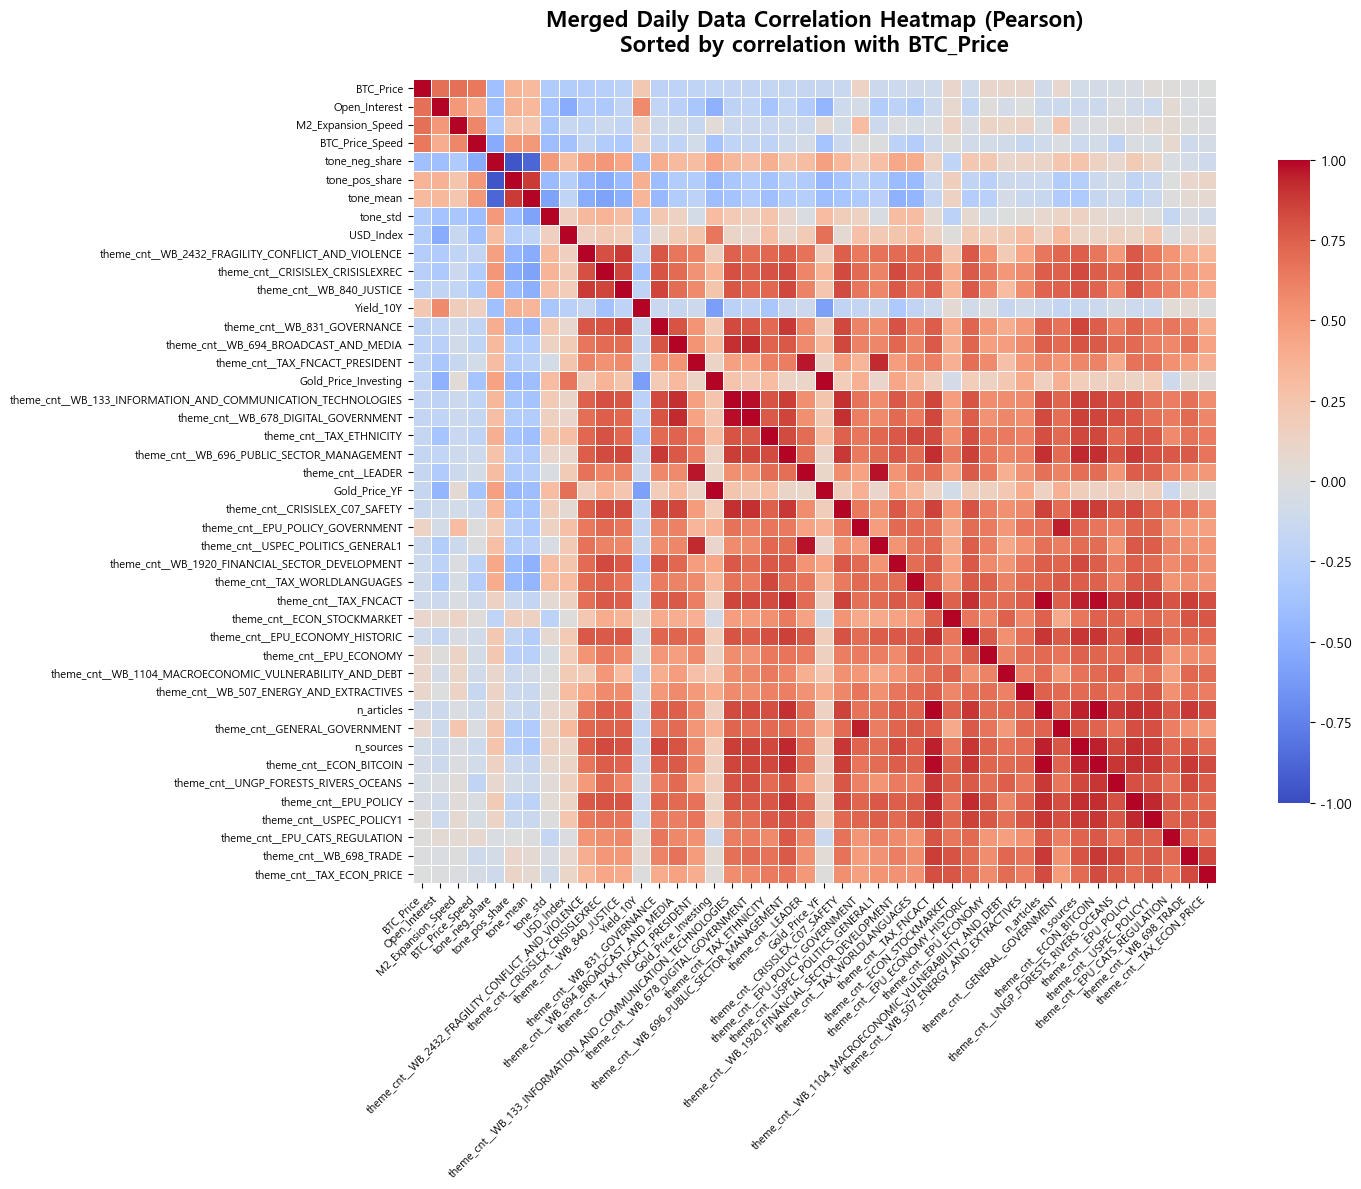


🎉 모든 분석이 완료되었습니다!

📁 생성된 파일: ./outputs\corr_heatmap.png


In [16]:
# ============================================================
# 셀 8: 상관관계 히트맵 생성 및 저장
# ============================================================

print("🎨 상관관계 히트맵 생성 중...\n")

# 컬럼 수에 따라 annot(숫자 표시) 여부 결정
num_cols = len(corr_matrix.columns)
show_annot = num_cols <= HEATMAP_ANNOT_THRESHOLD

if show_annot:
    print(f"   컬럼 수 {num_cols}개 → annot=True (상관계수 숫자 표시)")
else:
    print(f"   컬럼 수 {num_cols}개 → annot=False (숫자 표시 안 함, 가독성 우선)")

# Figure 생성
fig, ax = plt.subplots(figsize=HEATMAP_FIGSIZE)

# 히트맵 그리기
sns.heatmap(
    corr_matrix,
    annot=show_annot,           # 숫자 표시 여부
    fmt='.2f',                   # 숫자 포맷 (소수점 2자리)
    cmap='coolwarm',             # 색상: 파란색(음수) ~ 빨간색(양수)
    vmin=-1,                     # 최소값 -1로 고정
    vmax=1,                      # 최대값 1로 고정
    center=0,                    # 중심값 0
    square=True,                 # 정사각형 셀
    linewidths=0.5,              # 셀 경계선 두께
    cbar_kws={'shrink': 0.8},    # 컬러바 크기
    ax=ax
)

# 제목 설정
title_text = f'Merged Daily Data Correlation Heatmap ({CORR_METHOD.capitalize()})'
if btc_col:
    title_text += f'\nSorted by correlation with {btc_col}'

ax.set_title(
    title_text,
    fontsize=16,
    fontweight='bold',
    pad=20
)

# x축, y축 레이블 회전 및 정렬
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# 레이아웃 자동 조정 (레이블이 잘리지 않도록)
plt.tight_layout()

# ============================================================
# 이미지 파일로 저장
# ============================================================

# 출력 디렉토리 생성 (없으면 생성)
os.makedirs(OUTPUT_DIR, exist_ok=True)
output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILE)

# 이미지 저장
plt.savefig(
    output_path,
    dpi=300,              # 고해상도
    bbox_inches='tight',  # 여백 최소화
    facecolor='white'     # 배경색 흰색
)

print(f"\n✅ 히트맵 저장 완료: {output_path}")
print(f"   이미지 크기: {HEATMAP_FIGSIZE[0]} x {HEATMAP_FIGSIZE[1]} inches")
print(f"   해상도: 300 DPI")

# 화면에 표시
plt.show()

print("\n🎉 모든 분석이 완료되었습니다!")
print(f"\n📁 생성된 파일: {output_path}")

In [17]:
# ============================================================
# 셀 9: (선택사항) 추가 분석 - 상관관계 통계 요약
# ============================================================

print("📈 상관관계 통계 요약\n")
print("="*80)

if btc_col:
    # BTC_Price와의 상관계수 통계
    btc_corr_stats = corr_matrix[btc_col].drop(btc_col).describe()
    
    print(f"\n🎯 {btc_col}와의 상관계수 통계")
    print("-" * 80)
    print(f"{'항목':<20} {'값':>15}")
    print("-" * 80)
    print(f"{'총 변수 수':<20} {int(btc_corr_stats['count']):>15,}")
    print(f"{'평균':<20} {btc_corr_stats['mean']:>15.4f}")
    print(f"{'표준편차':<20} {btc_corr_stats['std']:>15.4f}")
    print(f"{'최소값 (음의 상관)':<20} {btc_corr_stats['min']:>15.4f}")
    print(f"{'25% 백분위':<20} {btc_corr_stats['25%']:>15.4f}")
    print(f"{'중앙값':<20} {btc_corr_stats['50%']:>15.4f}")
    print(f"{'75% 백분위':<20} {btc_corr_stats['75%']:>15.4f}")
    print(f"{'최대값 (양의 상관)':<20} {btc_corr_stats['max']:>15.4f}")
    
    # 강한 상관관계 변수 개수
    btc_corr_values = corr_matrix[btc_col].drop(btc_col)
    strong_positive = (btc_corr_values >= 0.7).sum()
    moderate_positive = ((btc_corr_values >= 0.4) & (btc_corr_values < 0.7)).sum()
    weak = ((btc_corr_values > -0.4) & (btc_corr_values < 0.4)).sum()
    moderate_negative = ((btc_corr_values <= -0.4) & (btc_corr_values > -0.7)).sum()
    strong_negative = (btc_corr_values <= -0.7).sum()
    
    print(f"\n📊 상관관계 강도별 변수 분포")
    print("-" * 80)
    print(f"{'강도':<30} {'변수 수':>15} {'비율':>15}")
    print("-" * 80)
    total_vars = len(btc_corr_values)
    print(f"{'강한 양의 상관 (≥ 0.7)':<30} {strong_positive:>15} {strong_positive/total_vars*100:>14.1f}%")
    print(f"{'중간 양의 상관 (0.4~0.7)':<30} {moderate_positive:>15} {moderate_positive/total_vars*100:>14.1f}%")
    print(f"{'약한 상관 (-0.4~0.4)':<30} {weak:>15} {weak/total_vars*100:>14.1f}%")
    print(f"{'중간 음의 상관 (-0.7~-0.4)':<30} {moderate_negative:>15} {moderate_negative/total_vars*100:>14.1f}%")
    print(f"{'강한 음의 상관 (≤ -0.7)':<30} {strong_negative:>15} {strong_negative/total_vars*100:>14.1f}%")

# 전체 상관행렬 통계
print(f"\n🌐 전체 상관행렬 통계")
print("-" * 80)

# 상관행렬에서 대각선 제외 (자기 자신과의 상관계수 1 제외)
corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]

print(f"총 변수 쌍 수: {len(corr_values):,}")
print(f"평균 상관계수: {np.mean(corr_values):.4f}")
print(f"중앙값: {np.median(corr_values):.4f}")
print(f"표준편차: {np.std(corr_values):.4f}")
print(f"최소값: {np.min(corr_values):.4f}")
print(f"최대값: {np.max(corr_values):.4f}")

print("\n✅ 통계 요약 완료!")

📈 상관관계 통계 요약


🎯 BTC_Price와의 상관계수 통계
--------------------------------------------------------------------------------
항목                                 값
--------------------------------------------------------------------------------
총 변수 수                            43
평균                           -0.0232
표준편차                          0.2489
최소값 (음의 상관)                  -0.3858
25% 백분위                      -0.1748
중앙값                          -0.0982
75% 백분위                       0.0881
최대값 (양의 상관)                   0.6864

📊 상관관계 강도별 변수 분포
--------------------------------------------------------------------------------
강도                                        변수 수              비율
--------------------------------------------------------------------------------
강한 양의 상관 (≥ 0.7)                             0            0.0%
중간 양의 상관 (0.4~0.7)                           3            7.0%
약한 상관 (-0.4~0.4)                            40           93.0%
중간 음의 상관 (-0.7~-0.4)                